In [1]:
from pathlib import Path
from importlib import reload
#Intel optimizations for sklearn
from sklearnex import patch_sklearn
patch_sklearn()
import matplotlib as mpl
import matplotlib.patches as mpl_patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from scipy.ndimage import median_filter

import cdetools
import corner
import flexcode
# import qp
# import rail
# import rfcde

import utils
reload(utils)

from utils import get_pit, plot_pit
import ispline
from ispline import fit_cdf, get_pdf

reload(ispline)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<module 'ispline' from '/home/bid13/code/photoz_diagnostics/qtc2021/ispline.py'>

In [67]:
params = {
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
    "figure.facecolor": "w",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "font.family": "serif",
    "mathtext.fontset": "dejavuserif"
}
plt.rcParams.update(params)

In [3]:
# data = np.load("../figs/data.npz")
# cde_test_B = data["cde_test_B"]
# cde_test_C = data["cde_test_C"]
# correction_cde_B = data["correction_cde_B"]
# correction_cde_C = data["correction_cde_C"]
# y_grid_test_B = data["y_grid_test_B"]
# y_grid_test_C = data["y_grid_test_C"]
# correction_global_C=data["correction_global_C"]

In [4]:
# debiased_pdf_bordoloi_B = cde_test_B * correction_cde_B
# norm = np.sum(np.gradient(np.squeeze(y_grid_test_B)) * debiased_pdf_bordoloi_B, axis=-1, keepdims=True)
# debiased_pdf_bordoloi_B = debiased_pdf_bordoloi_B/norm

# debiased_pdf_bordoloi_C = cde_test_C * correction_cde_C
# norm = np.sum(np.gradient(np.squeeze(y_grid_test_C)) * debiased_pdf_bordoloi_C, axis=-1, keepdims=True)
# debiased_pdf_bordoloi_C = debiased_pdf_bordoloi_C/norm

In [76]:
from scipy.integrate import trapezoid


def anderson_darling_statistic(cdf_test, cdf_ref, n_tot=1):
    """
    cdf_test: CDF of the test distribution (1D array)
    cdf_ref: CDF of the reference distribution on the same grid (1D array)
    n_tot:Scaling factor equal to the number of PDFs used to construct ECDF
    """
    num = (cdf_test - cdf_ref) ** 2
    den = cdf_ref * (1 - cdf_ref)

    ad2 = n_tot * trapezoid((num / den), cdf_ref)
    return np.sqrt(ad2)

### Estimating photo-$z$ posterior PDFs with RFCDE on TEDDY.

Trying to replicate results from Nicc's paper.

In [6]:
# data generated via teddy data
BASE_PATH = Path("../photoz_catalogues/Teddy/")

# train/validation data
x_train_val = pd.read_csv(
    BASE_PATH / "teddy_A", skiprows=7, delim_whitespace=True, header=None
).to_numpy()[:, 7:]
y_train_val = pd.read_csv(
    BASE_PATH / "teddy_A", skiprows=7, delim_whitespace=True, header=None
).to_numpy()[:, 6]

# split the train_val into train and validation
frac_train = 0.7
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val,
    y_train_val,
    train_size=int(frac_train * x_train_val.shape[0]),
    random_state=42,
)

# test
x_test_B = pd.read_csv(
    BASE_PATH / "teddy_B", skiprows=7, delim_whitespace=True, header=None
).to_numpy()[:, 7:]
y_test_B = pd.read_csv(
    BASE_PATH / "teddy_B", skiprows=7, delim_whitespace=True, header=None
).to_numpy()[:, 6]

x_test_C = pd.read_csv(
    BASE_PATH / "teddy_C", skiprows=7, delim_whitespace=True, header=None
).to_numpy()[:, 7:]
y_test_C = pd.read_csv(
    BASE_PATH / "teddy_C", skiprows=7, delim_whitespace=True, header=None
).to_numpy()[:, 6]

x_test_D = pd.read_csv(
    BASE_PATH / "teddy_D", skiprows=7, delim_whitespace=True, header=None
).to_numpy()[:, 7:]
y_test_D = pd.read_csv(
    BASE_PATH / "teddy_D", skiprows=7, delim_whitespace=True, header=None
).to_numpy()[:, 6]

### FlexZBoost

In [7]:
import xgboost as xgb
from cdetools.cde_loss import cde_loss
from flexcode.regression_models import XGBoost  

In [8]:
# Parameterize model
model = flexcode.FlexCodeModel(
    XGBoost,
    max_basis=31,
    basis_system="cosine",
    regression_params={
        "max_depth": 3,
        "learning_rate": 0.5,
        "objective": "reg:squarederror",
        "tree_method": "gpu_hist",
        "gpu_id": 0,
        "verbosity":0,
    },
)

# Fit and tune model
model.fit(x_train, y_train)


/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[14:16:12] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:16:13] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:16:17] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:16:21] WARNI

In [9]:
cde_val, y_grid_val = model.predict(x_val, n_grid=1000)
cde_test_B, y_grid_test_B = model.predict(x_test_B, n_grid=1000)
cde_test_C, y_grid_test_C = model.predict(x_test_C, n_grid=1000)
cde_test_D, y_grid_test_D = model.predict(x_test_D, n_grid=1000)

In [10]:
cde_loss_val_B, std_cde_loss_B = cde_loss(cde_test_B, y_grid_test_B, y_test_B)
print("CDE Loss for TEDDY B: %4.2f \pm %.2f" % (cde_loss_val_B, std_cde_loss_B))
cde_loss_val_C, std_cde_loss_C = cde_loss(cde_test_C, y_grid_test_C, y_test_C)
print("CDE Loss for TEDDY C: %4.2f \pm %.2f" % (cde_loss_val_C, std_cde_loss_C))
# cde_loss_val_D, std_cde_loss_D = cde_loss(cde_test_D, y_grid_test_D, y_test_D)
# print("CDE Loss for TEDDY D: %4.2f \pm %.2f" % (cde_loss_val_D, std_cde_loss_D))

CDE Loss for TEDDY B: -12.59 \pm 0.04
CDE Loss for TEDDY C: -12.55 \pm 0.04


In [11]:
# bump_threshold_vec = [5e-2, 1e-1, 5e-1]
# # sharpen_vec = np.linspace(1, 2, 10)
# model.tune(
#     x_val,
#     y_val,
#     bump_threshold_grid=bump_threshold_vec,
# #     sharpen_grid=sharpen_vec,
#     n_grid=1000,
# )
# print("Best Bump Removal Threshold: %s" % model.bump_threshold)
# # print("Best Sharpen Alpha: %s" % model.sharpen_alpha)

In [12]:
# cde_val, y_grid_val = model.predict(x_val, n_grid=1000)
# cde_test_B, y_grid_test_B = model.predict(x_test_B, n_grid=1000)
# cde_test_C, y_grid_test_C = model.predict(x_test_C, n_grid=1000)
# cde_test_D, y_grid_test_D = model.predict(x_test_D, n_grid=1000)

# cde_loss_val_B, std_cde_loss_B = cde_loss(cde_test_B, y_grid_test_B, y_test_B)
# print("CDE Loss for TEDDY B: %4.2f \pm %.2f" % (cde_loss_val_B, std_cde_loss_B))
# cde_loss_val_C, std_cde_loss_C = cde_loss(cde_test_C, y_grid_test_C, y_test_C)
# print("CDE Loss for TEDDY C: %4.2f \pm %.2f" % (cde_loss_val_C, std_cde_loss_C))
# cde_loss_val_D, std_cde_loss_D = cde_loss(cde_test_D, y_grid_test_D, y_test_D)
# print("CDE Loss for TEDDY D: %4.2f \pm %.2f" % (cde_loss_val_D, std_cde_loss_D))

In [109]:
pit_val = get_pit(cde_val, y_grid_val, y_val)
pit_test_B = get_pit(cde_test_B, y_grid_test_B, y_test_B)
pit_test_C = get_pit(cde_test_C, y_grid_test_C, y_test_C)
# pit_test_D = get_pit(cde_test_D, y_grid_test_D, y_test_D)

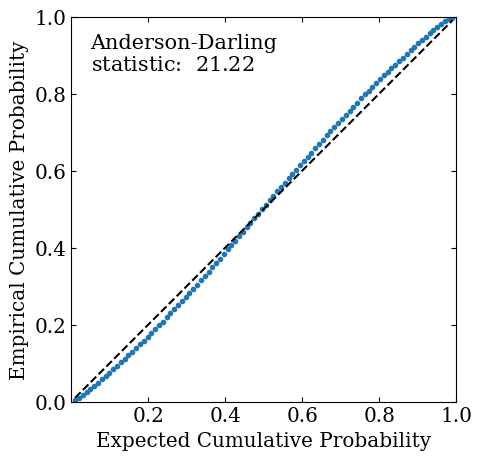

In [110]:
# plot P-P plot
prob_theory = np.linspace(0.01, 0.99, 100)
prob_data = [np.sum(pit_test_C < i) / len(pit_test_C) for i in prob_theory]
plt.figure(figsize=(5,5))
plt.scatter(prob_theory, prob_data, marker=".")
# plt.plot(prob_theory,prob_theory, c="white", ls="--")
plt.plot(prob_theory,prob_theory, c="k", ls="--")
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Expected Cumulative Probability")
plt.ylabel("Empirical Cumulative Probability")
ad = anderson_darling_statistic(prob_data,prob_theory, len(y_test_C))
# plt.text(0.05,0.9,f"CDE Loss:  ${cde_loss_val_C:.2f} \pm {std_cde_loss_C:.2f}$", fontsize=15)
plt.text(0.05,0.86,f"Anderson-Darling\nstatistic:  ${ad:.2f} $", fontsize=15)
xlabels = np.linspace(0,1,6)[1:]
plt.xticks(xlabels)
plt.gca().set_aspect('equal')
plt.savefig("../figs/P-P_global.pdf", bbox_inches="tight")
plt.show()

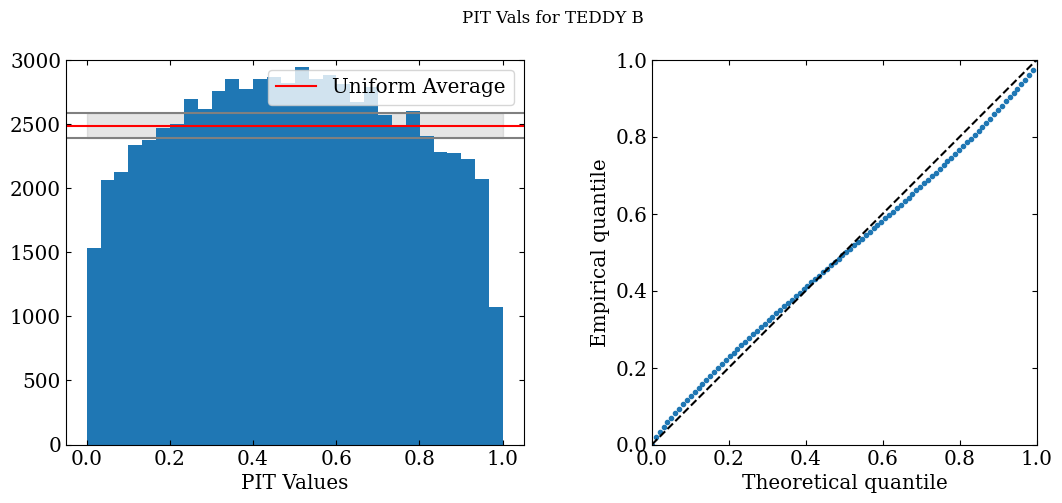

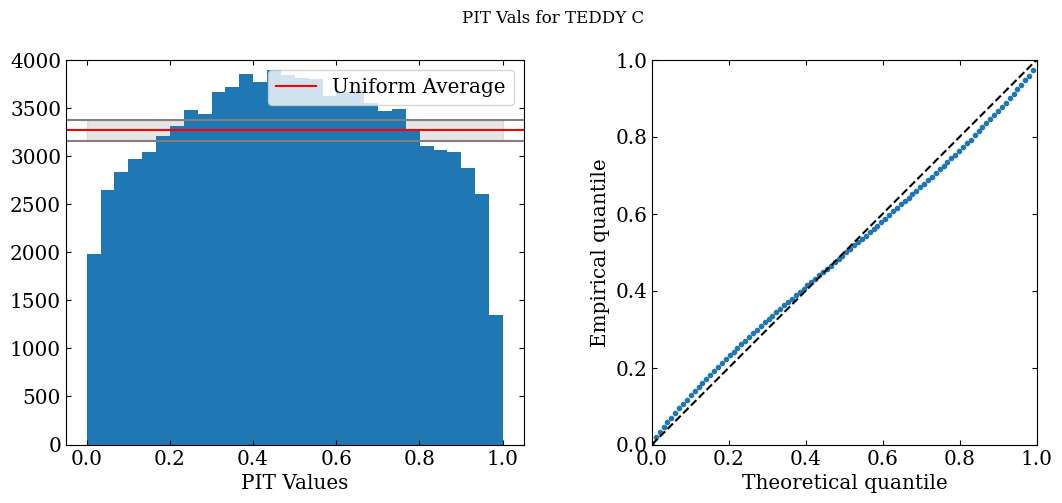

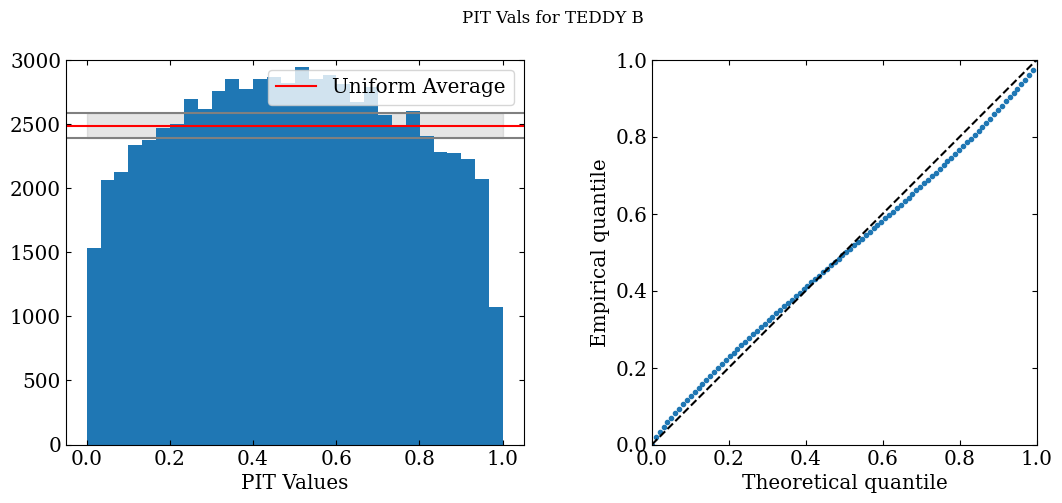

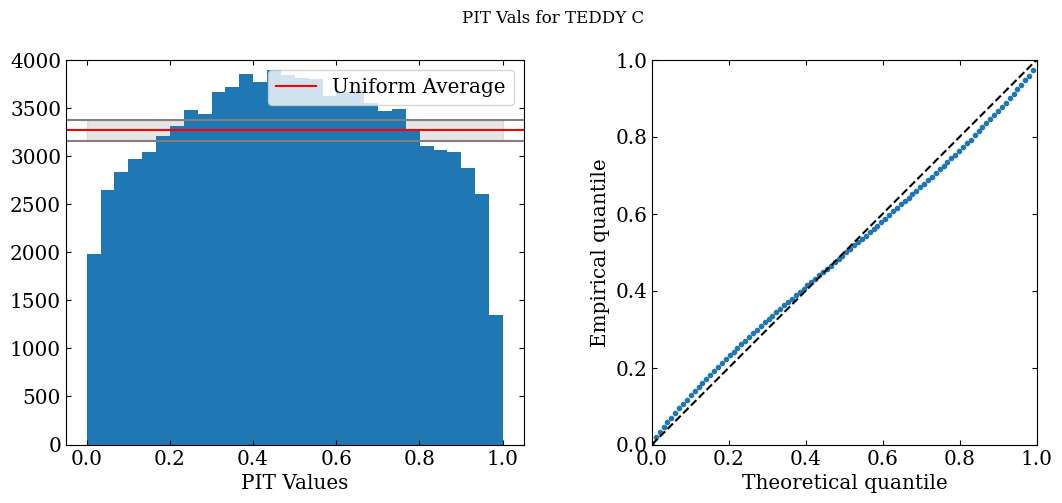

In [17]:
fig, ax = plot_pit(pit_values=pit_test_B,ci_level=0.95,figsize=(13,5))
ax[0].set_ylim(0,3000)
fig.suptitle("PIT Vals for TEDDY B")
fig, ax = plot_pit(pit_values=pit_test_C,ci_level=0.95,figsize=(13,5))
ax[0].set_ylim(0,4000)
fig.suptitle("PIT Vals for TEDDY C")
# fig, ax = plot_pit(pit_values=pit_test_D,ci_level=0.95,figsize=(13,5))
# ax[0].set_ylim(0,3000)
# fig.suptitle("PIT Vals for TEDDY D")
plt.show()

# Check for local callibration

In [18]:
from xgboost import XGBClassifier, XGBRegressor


def get_local_pit(
    x_validation,
    pit_validation,
    x_test,
    alphas=np.linspace(0.0000000001, 0.9999, 1001),
):

    clf = XGBClassifier(
        #         n_estimators=999,
        max_depth=3,
        #         learning_rate=0.02,
        tree_method="gpu_hist",
        gpu_id=0,
        #         verbose=0,
        #         min_child_weight=1,
        #         subsample=0.5,
        #         sampling_method="gradient_based",
        #         colsample_bytree=1,
        #         max_bin=512,
        objective="reg:squarederror",
    )

    ### calculate PIT values at point of interest x_test
    pit_values = np.zeros((len(x_test), len(alphas)))
    for alpha_count, alpha in enumerate(alphas):
        ind_validation = [1 * (x <= alpha) for x in pit_validation]
        rhat = clf
        rhat.fit(X=x_validation, y=ind_validation)
        pit_values[:, alpha_count] = rhat.predict_proba(x_test)[:, 1]
        print(f"{alpha_count+1}/{len(alphas)}", end="\r")
    print("\r")
    return pit_values

In [20]:
alphas = np.linspace(0.0, 1, 1001)

pit_local_B = get_local_pit(
    x_validation=x_val, pit_validation=pit_val, x_test=x_test_B, alphas=alphas
)
pit_local_C = get_local_pit(
    x_validation=x_val, pit_validation=pit_val, x_test=x_test_C, alphas=alphas
)
# pit_local_D = get_local_pit(
#     x_validation=x_val, pit_validation=pit_val, x_test=x_test_D, alphas=alphas
# )

1001/1001
1001/1001


### Plot local calibration plots along with the ispline fits to be used later

In [21]:
cdf_test_B = np.cumsum(np.gradient(np.squeeze(y_grid_test_B))*cde_test_B, axis=-1)
cdf_test_B[cdf_test_B>1]=1
cdf_test_C = np.cumsum(np.gradient(np.squeeze(y_grid_test_C))*cde_test_C, axis=-1) 
cdf_test_C[cdf_test_C>1]=1
# cdf_test_D = np.cumsum(np.gradient(np.squeeze(y_grid_test_D))*cde_test_C, axis=-1) 
# cdf_test_D[cdf_test_D>1]=1

In [22]:
num_basis = 6

In [23]:
pit_local_B_fit = np.zeros_like(cdf_test_B)
for  i in range(len(pit_local_B)):
    pit_local_B_fit[i,:], _,_= fit_cdf(alphas, pit_local_B[i,:], cdf_test_B[i,:], num_basis=num_basis)
    print(f"{i+1}/{len(pit_local_B)}", end="\r")
print("\r")

pit_local_C_fit = np.zeros_like(cdf_test_C)
for  i in range(len(pit_local_C)):
    pit_local_C_fit[i,:], _, _ = fit_cdf(alphas, pit_local_C[i,:], cdf_test_C[i,:], num_basis=num_basis)
    print(f"{i+1}/{len(pit_local_C)}", end="\r")
print("\r")
    
# pit_local_D_fit = np.zeros_like(cdf_test_D)
# for  i in range(len(pit_local_D)):
#     pit_local_D_fit[i,:], _, _ = fit_cdf(alphas, pit_local_D[i,:], cdf_test_D[i,:], num_basis=num_basis)
#     print(f"{i+1}/{len(pit_local_D)}", end="\r")
# print("\r")

74557/74557
97980/97980


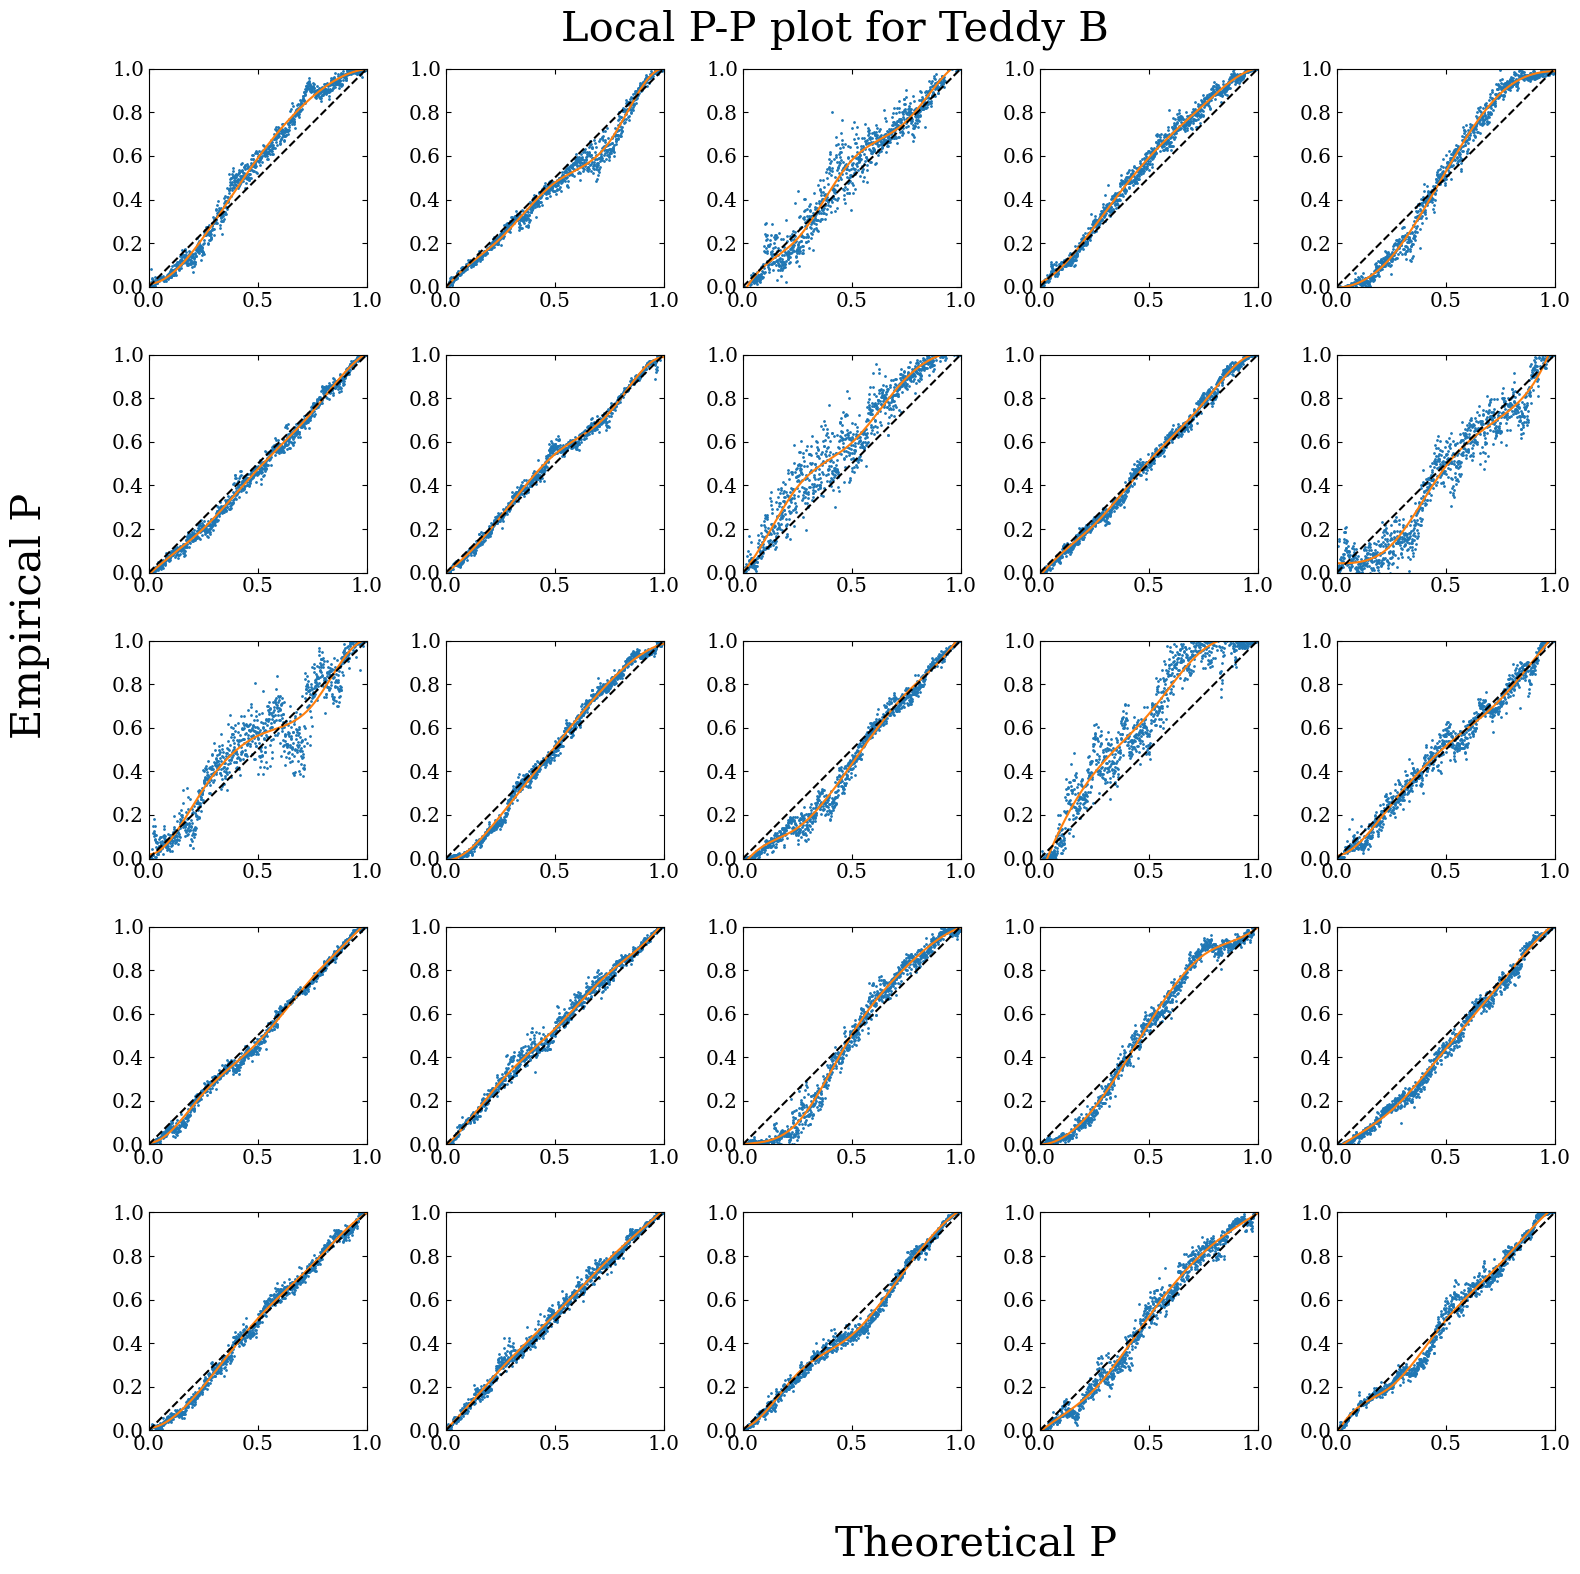

In [24]:
# Plot a random sample of 100 P-P plots

rng = np.random.default_rng(42)

random_idx = rng.choice(len(x_test_B), 25, replace=False)

fig, axs = plt.subplots(5,5, figsize=(15, 15))
axs = np.ravel(axs)

for count, index in enumerate(random_idx):
    axs[count].scatter(alphas, pit_local_B[index], s=1)
    axs[count].plot(cdf_test_B[index], pit_local_B_fit[index], c="C1")
    axs[count].plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), color="k", ls="--")
    axs[count].set_xlim(0, 1)
    axs[count].set_ylim(0, 1)
    axs[count].set_aspect("equal")
fig.suptitle("Local P-P plot for Teddy B", fontsize=30)
fig.text(0.5,-0.05,"Theoretical P", fontsize=30)
fig.text(-0.05,0.5,"Empirical P", rotation=90, fontsize=30)
plt.tight_layout()
plt.show()

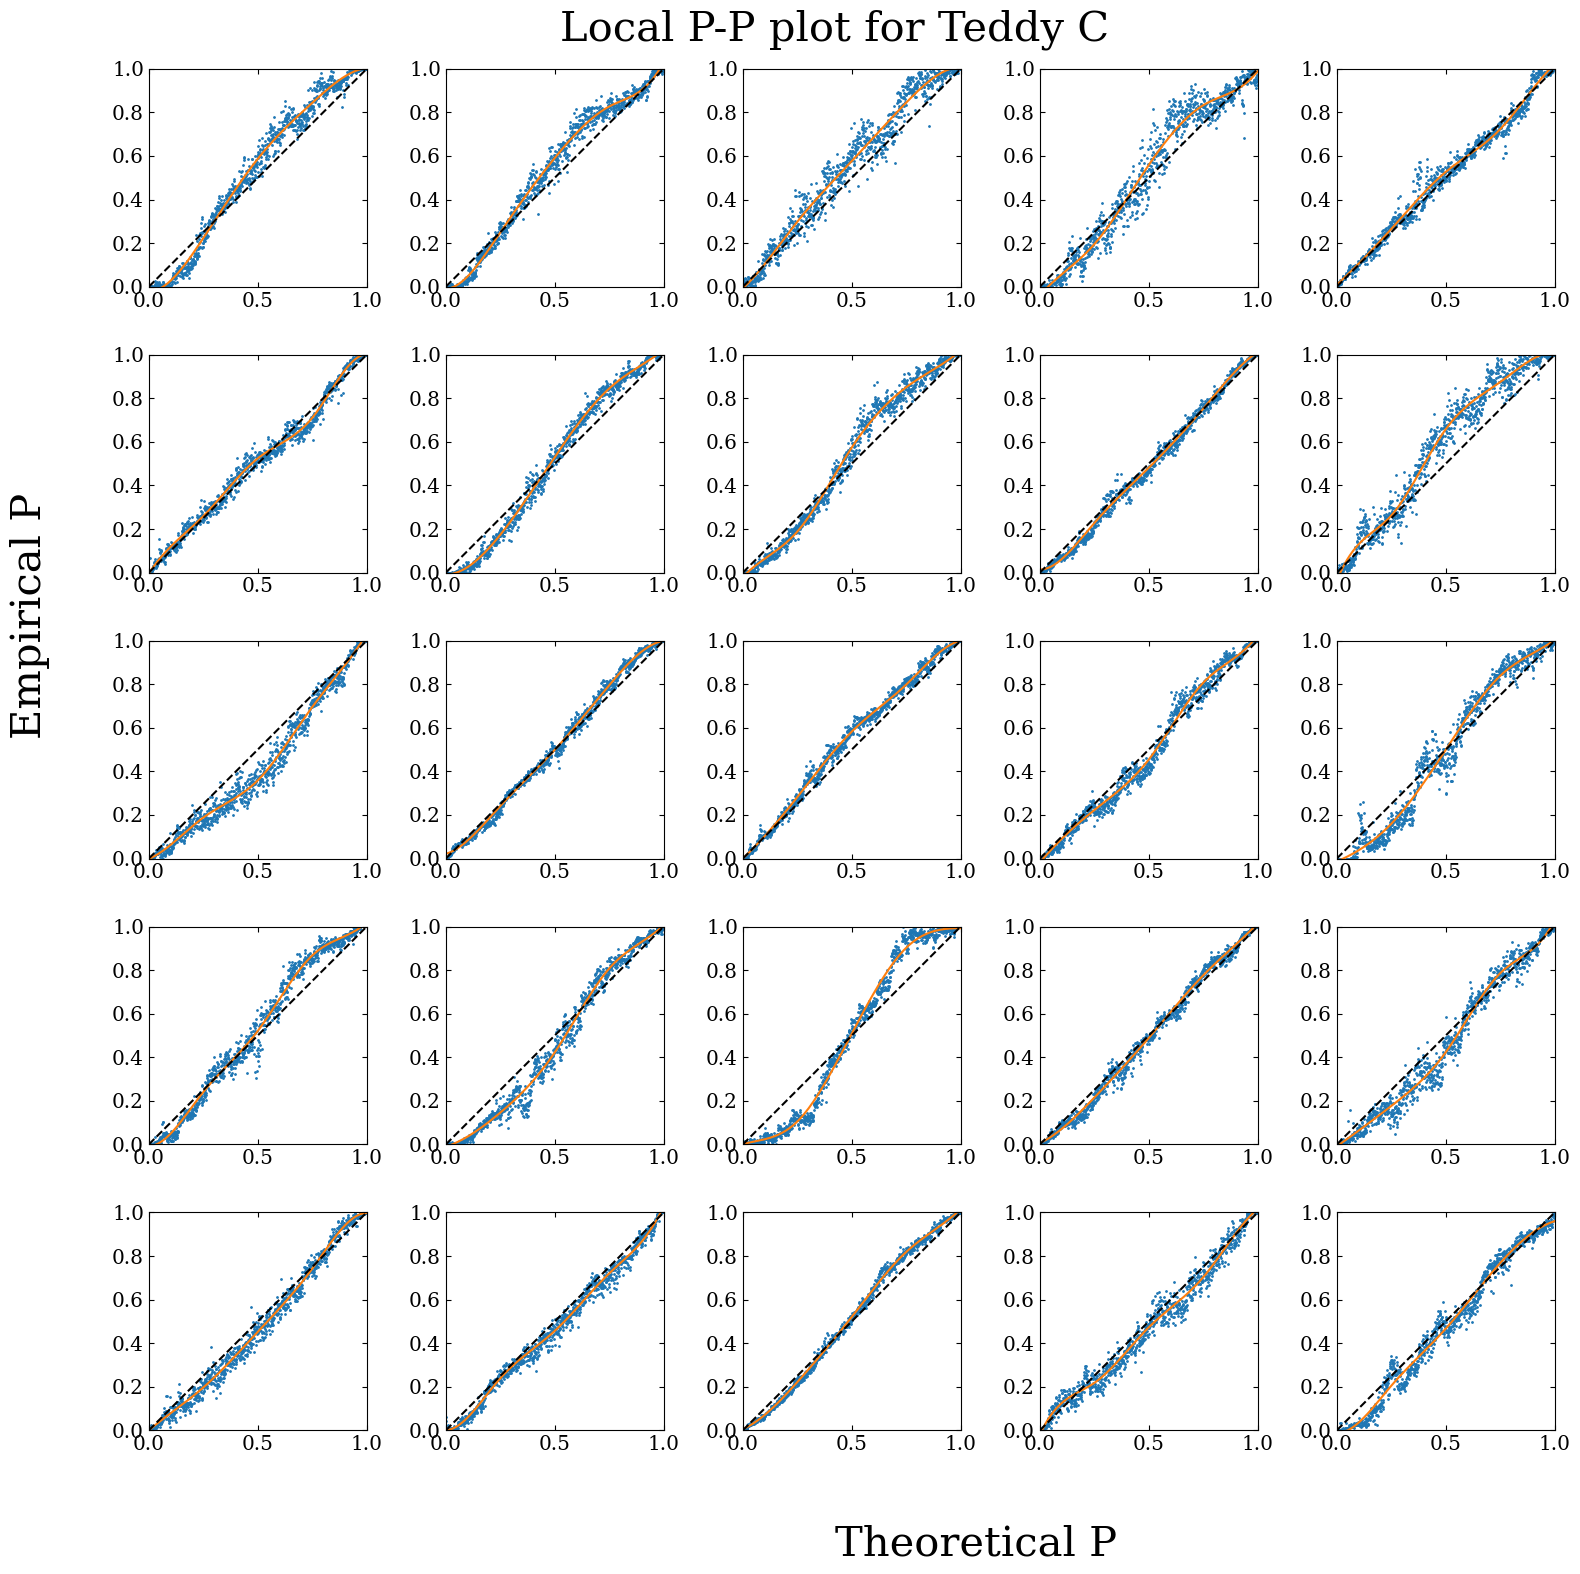

In [25]:
# Plot a random sample of 100 P-P plots

rng = np.random.default_rng(42)

random_idx = rng.choice(len(x_test_C), 25, replace=False)

fig, axs = plt.subplots(5,5, figsize=(15, 15))
axs = np.ravel(axs)

for count, index in enumerate(random_idx):
    axs[count].scatter(alphas, pit_local_C[index], s=1)
    axs[count].plot(cdf_test_C[index], pit_local_C_fit[index], c="C1")
    axs[count].plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), color="k", ls="--")
    axs[count].set_xlim(0, 1)
    axs[count].set_ylim(0, 1)
    axs[count].set_aspect("equal")
fig.suptitle("Local P-P plot for Teddy C", fontsize=30)
fig.text(0.5,-0.05,"Theoretical P", fontsize=30)
fig.text(-0.05,0.5,"Empirical P", rotation=90, fontsize=30)
plt.tight_layout()
plt.show()

### Re-calibrate based on global PIT

In [26]:
num_bins = 1000
pops, bins = np.histogram(pit_val, bins=num_bins, density=True)

In [27]:
n_grid=1000
correction_global_C = np.zeros((len(x_test_C), n_grid))
#VECTORIZE (also vectorize the loop inside the function)
for i in range(len(x_test_C)):
    correction_global_C[i] = get_pit(np.tile(cde_test_C[i], (n_grid, 1)), y_grid_test_C, y_grid_test_C)
    print(f"{i+1}/{len(x_test_C)}", end="\r")

In [28]:
# Binned correction
bin_idx = np.digitize(correction_global_C, bins) - 1
bin_idx[bin_idx == num_bins] = num_bins - 1

correction_global_C = pops[bin_idx]

# Re-calibrate based on local Pitt

In [29]:
correction_cde_B = np.zeros_like(cdf_test_B)
cdf_test_B[cdf_test_B>1]=1
for  i in range(len(correction_cde_B)):
    correction_cde_B[i,:],_,_  = get_pdf(alphas, pit_local_B[i,:], cdf_test_B[i,:], num_basis=num_basis)
    print(f"{i+1}/{len(correction_cde_B)}", end="\r")
print("\r")

correction_cde_C = np.zeros_like(cde_test_C)
cdf_test_C[cdf_test_C>1]=1
for  i in range(len(correction_cde_C)):
    correction_cde_C[i,:], _,_  = get_pdf(alphas, pit_local_C[i,:], cdf_test_C[i,:], num_basis=num_basis)
    print(f"{i+1}/{len(correction_cde_C)}", end="\r")
print("\r")

# correction_cde_D = np.zeros_like(cde_test_D)
# cdf_test_D[cdf_test_D>1]=1
# for  i in range(len(correction_cde_D)):
#     correction_cde_D[i,:], _,_  = get_pdf(alphas, pit_local_D[i,:], cdf_test_D[i,:], num_basis=num_basis)
#     print(f"{i+1}/{len(correction_cde_D)}", end="\r")
# print("\r")

74557/74557
97980/97980


In [30]:
mask = ~np.all(np.isfinite(correction_cde_B), axis=-1)
correction_cde_B[mask,:] = 1

mask = ~np.all(np.isfinite(correction_cde_C), axis=-1)
correction_cde_C[mask,:] = 1

# mask = ~np.all(np.isfinite(correction_cde_D), axis=-1)
# correction_cde_D[mask,:] = 1

In [31]:
debiased_pdf_bordoloi_B = cde_test_B * correction_cde_B
norm = np.sum(np.gradient(np.squeeze(y_grid_test_B)) * debiased_pdf_bordoloi_B, axis=-1, keepdims=True)
debiased_pdf_bordoloi_B = debiased_pdf_bordoloi_B/norm

debiased_pdf_bordoloi_C = cde_test_C * correction_cde_C
norm = np.sum(np.gradient(np.squeeze(y_grid_test_C)) * debiased_pdf_bordoloi_C, axis=-1, keepdims=True)
debiased_pdf_bordoloi_C = debiased_pdf_bordoloi_C/norm

# debiased_pdf_bordoloi_D = cde_test_D * correction_cde_D
# norm = np.sum(np.gradient(np.squeeze(y_grid_test_D)) * debiased_pdf_bordoloi_D, axis=-1, keepdims=True)
# debiased_pdf_bordoloi_D = debiased_pdf_bordoloi_D/norm

In [32]:
cde_loss_val_B, std_cde_loss_B = cde_loss(debiased_pdf_bordoloi_B, y_grid_test_B, y_test_B)
print("CDE Loss for TEDDY B after debiasing: %4.2f \pm %.2f" % (cde_loss_val_B, std_cde_loss_B))

cde_loss_val_C, std_cde_loss_C = cde_loss(debiased_pdf_bordoloi_C, y_grid_test_C, y_test_C)
print("CDE Loss for TEDDY C after debiasing: %4.2f \pm %.2f" % (cde_loss_val_C, std_cde_loss_C))

# cde_loss_val_D, std_cde_loss_D = cde_loss(debiased_pdf_bordoloi_D, y_grid_test_D, y_test_D)
# print("CDE Loss for TEDDY D after debiasing: %4.2f \pm %.2f" % (cde_loss_val_D, std_cde_loss_D))

CDE Loss for TEDDY B after debiasing: -12.68 \pm 0.06
CDE Loss for TEDDY C after debiasing: -12.63 \pm 0.05


In [90]:
pit_test_B = get_pit(debiased_pdf_bordoloi_B, y_grid_test_B, y_test_B)
pit_test_C = get_pit(debiased_pdf_bordoloi_C, y_grid_test_C, y_test_C)
# pit_test_D = get_pit(debiased_pdf_bordoloi_D, y_grid_test_D, y_test_D)

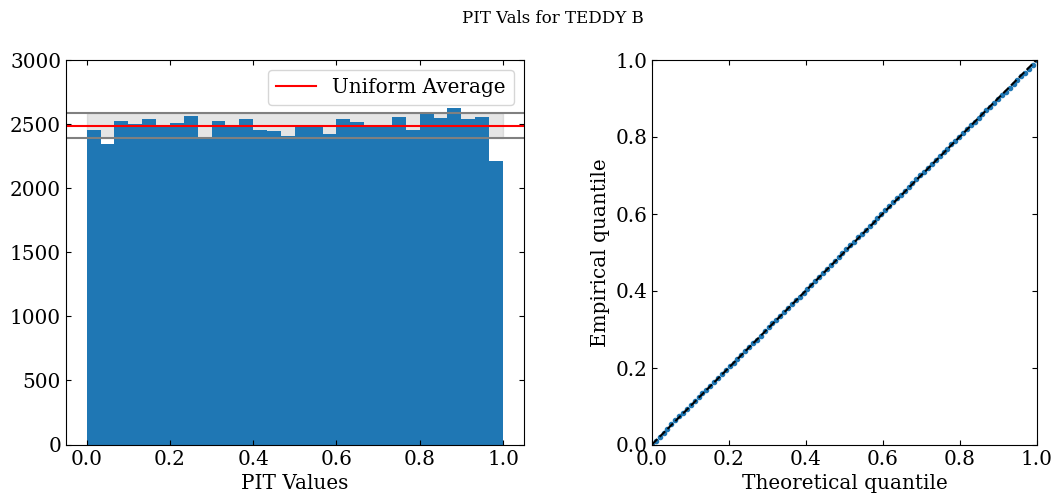

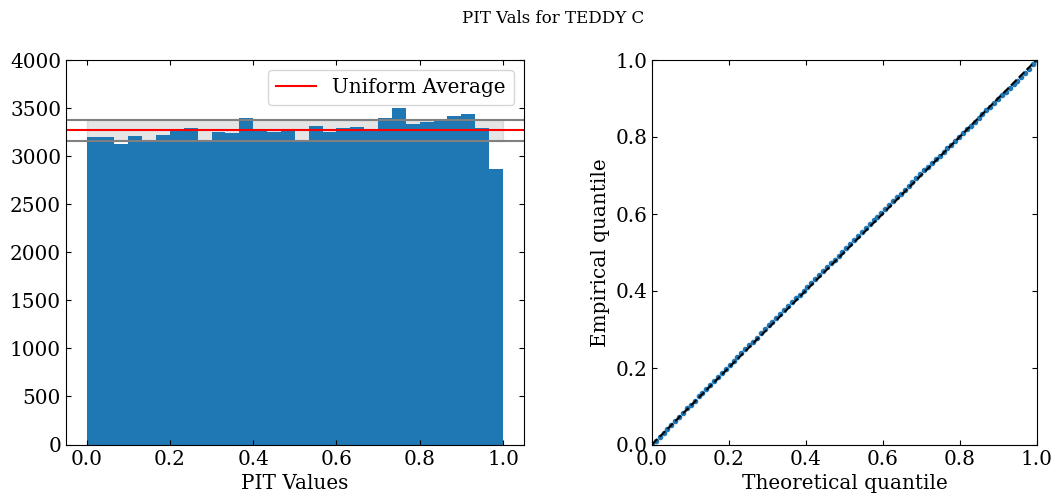

In [34]:
fig, ax = plot_pit(pit_values=pit_test_B,ci_level=0.95,figsize=(13,5))
ax[0].set_ylim(0,3000)
fig.suptitle("PIT Vals for TEDDY B")
fig, ax = plot_pit(pit_values=pit_test_C,ci_level=0.95,figsize=(13,5))
ax[0].set_ylim(0,4000)
fig.suptitle("PIT Vals for TEDDY C")
# fig, ax = plot_pit(pit_values=pit_test_D,ci_level=0.95,figsize=(13,5))
# ax[0].set_ylim(0,3000)
# fig.suptitle("PIT Vals for TEDDY D")
plt.show()

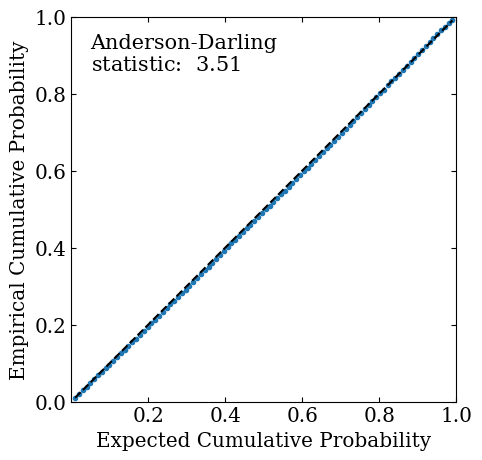

In [108]:
# plot P-P plot
prob_theory = np.linspace(0.01, 0.99, 100)
prob_data = [np.sum(pit_test_C < i) / len(pit_test_C) for i in prob_theory]
plt.figure(figsize=(5,5))
plt.scatter(prob_theory, prob_data, marker=".")
plt.plot(prob_theory,prob_theory, c="k", ls="--")
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Expected Cumulative Probability")
plt.ylabel("Empirical Cumulative Probability")
ad = anderson_darling_statistic(prob_data, prob_theory, len(y_test_C))
# plt.text(0.05,0.9,f"CDE Loss:  ${cde_loss_val_C:.2f} \pm {std_cde_loss_C:.2f}$", fontsize=15)
plt.text(0.05,0.86,f"Anderson-Darling\nstatistic:  ${ad:.2f} $", fontsize=15)
xlabels = np.linspace(0,1,6)[1:]
plt.xticks(xlabels)
plt.gca().set_aspect('equal')
plt.savefig("../figs/P-P_global_recal.pdf", bbox_inches="tight")
plt.show()

# Check for local callibration after debiasing

Here we need to divide up the test set to do the checking

In [36]:
deb_pit_test_B = get_pit(debiased_pdf_bordoloi_B, y_grid_test_B, y_test_B)
deb_pit_test_C = get_pit(debiased_pdf_bordoloi_C, y_grid_test_C, y_test_C)

In [37]:
# split the train_val into train and validation
frac_val = 0.5

rng = np.random.default_rng(42)

idx_B = rng.permutation(len(x_test_B))
idx_split_B = int(frac_val * len(x_test_B))

idx_C = rng.permutation(len(x_test_C))
idx_split_C = int(frac_val * len(x_test_C))


In [38]:
pit_local_B_recal = get_local_pit(
    x_validation=x_test_B[idx_B[:idx_split_B,]],
    pit_validation=deb_pit_test_B[idx_B[:idx_split_B,]],
    x_test=x_test_B[idx_B[idx_split_B:,]],
    alphas=alphas,
)
pit_local_C_recal = get_local_pit(
    x_validation=x_test_C[idx_C[:idx_split_C,]],
    pit_validation=deb_pit_test_C[idx_C[:idx_split_C,]],
    x_test=x_test_C[idx_C[idx_split_C:,]],
    alphas=alphas,
)

/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


1001/1001
1001/1001


In [39]:
debiased_pdf_global_C = cde_test_C * correction_global_C
norm = np.sum(np.gradient(np.squeeze(y_grid_test_C)) * debiased_pdf_global_C, axis=-1, keepdims=True)
debiased_pdf_global_C = debiased_pdf_global_C/norm

deb_pit_global_test_C = get_pit(debiased_pdf_global_C, y_grid_test_C, y_test_C)


pit_global_C_recal = get_local_pit(
    x_validation=x_test_C[idx_C[:idx_split_C,]],
    pit_validation=deb_pit_global_test_C[idx_C[:idx_split_C,]],
    x_test=x_test_C[idx_C[idx_split_C:,]],
    alphas=alphas,
)

1001/1001


In [40]:
# # Plot a random sample of 100 P-P plots

# rng = np.random.default_rng(42)

# random_idx = rng.choice(int((1-frac_val)*len(x_test_B)), 25, replace=False)

# fig, axs = plt.subplots(5,5, figsize=(15, 15))
# axs = np.ravel(axs)

# for count, index in enumerate(random_idx):
#     axs[count].scatter(alphas, pit_local_B_recal[index], s=1)
#     axs[count].plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), color="k", ls="--")
#     axs[count].set_xlim(0, 1)
#     axs[count].set_ylim(0, 1)
#     axs[count].set_aspect("equal")
# fig.suptitle("Local P-P plot for Teddy B", fontsize=30)
# fig.text(0.5,-0.05,"Theoretical P", fontsize=30)
# fig.text(-0.05,0.5,"Empirical P", rotation=90, fontsize=30)
# plt.tight_layout()
# plt.show()

In [41]:
# # Plot a random sample of 100 P-P plots

# rng = np.random.default_rng(42)

# random_idx = rng.choice(int((1-frac_val)*len(x_test_C)), 25, replace=False)

# fig, axs = plt.subplots(5,5, figsize=(15, 15))
# axs = np.ravel(axs)

# for count, index in enumerate(random_idx):
#     axs[count].scatter(alphas, pit_local_C_recal[index], s=1)
#     axs[count].plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), color="k", ls="--")
#     axs[count].set_xlim(0, 1)
#     axs[count].set_ylim(0, 1)
#     axs[count].set_aspect("equal")
# fig.suptitle("Local P-P plot for Teddy C", fontsize=30)
# fig.text(0.5,-0.05,"Theoretical P", fontsize=30)
# fig.text(-0.05,0.5,"Empirical P", rotation=90, fontsize=30)
# plt.tight_layout()
# plt.show()

In [42]:
# fig, ax = plt.subplots(2,5, figsize=(20,7))
# random_idx = rng.choice(int((1-frac_val)*len(x_test_B)), 25, replace=False)
# for i in range(5):
#     j=i+6
#     ax[0,i].scatter(alphas, pit_local_B[idx_B[idx_split_B:,]][random_idx[j]], marker=".",c="C0")
#     ax[0,i].plot(cdf_test_B[idx_B[idx_split_B:,]][random_idx[j]], pit_local_B_fit[idx_B[idx_split_B:,]][random_idx[j]], c="C1",lw=2)
#     x= np.linspace(0,1,10)
#     ax[0,i].plot(x,x,c="k",ls="--", lw=2)
#     ax[0,i].set_aspect("equal")
#     ax[0,i].set_xlim(0,1)
#     ax[0,i].set_ylim(0,1)
#     xlabels = np.linspace(0,1,6)[1:]
#     ax[0,i].set_xticks(xlabels)
#     ax[0,i].tick_params(axis='x', labelsize=15 )
#     ax[0,i].tick_params(axis='y', labelsize=15 )
    
#     ax[1,i].scatter(alphas, pit_local_B_recal[random_idx[j]], marker=".")
#     ax[1,i].plot(x,x,c="k",ls="--", lw=2)
#     ax[1,i].set_aspect("equal")
#     ax[1,i].set_xlim(0,1)
#     ax[1,i].set_ylim(0,1)
#     ax[1,i].tick_params(axis='x', labelsize=15 )
#     ax[1,i].tick_params(axis='y', labelsize=15 )
#     ax[1,i].set_xticks(xlabels)
# ax[0,0].set_ylabel("Original", fontsize=25)
# ax[1,0].set_ylabel("Re-Calibrated", fontsize=25)

# fig.text(0.35,0, r"Expected Cumulative Probability ($\alpha$)", fontsize=30)
# fig.text(0.05,0., r"Empirical Cumulative Probability ($\beta$)",rotation=90, fontsize=30)
# # plt.savefig("P-P_local.pdf")
# plt.show()
# # plt.tight_layout()

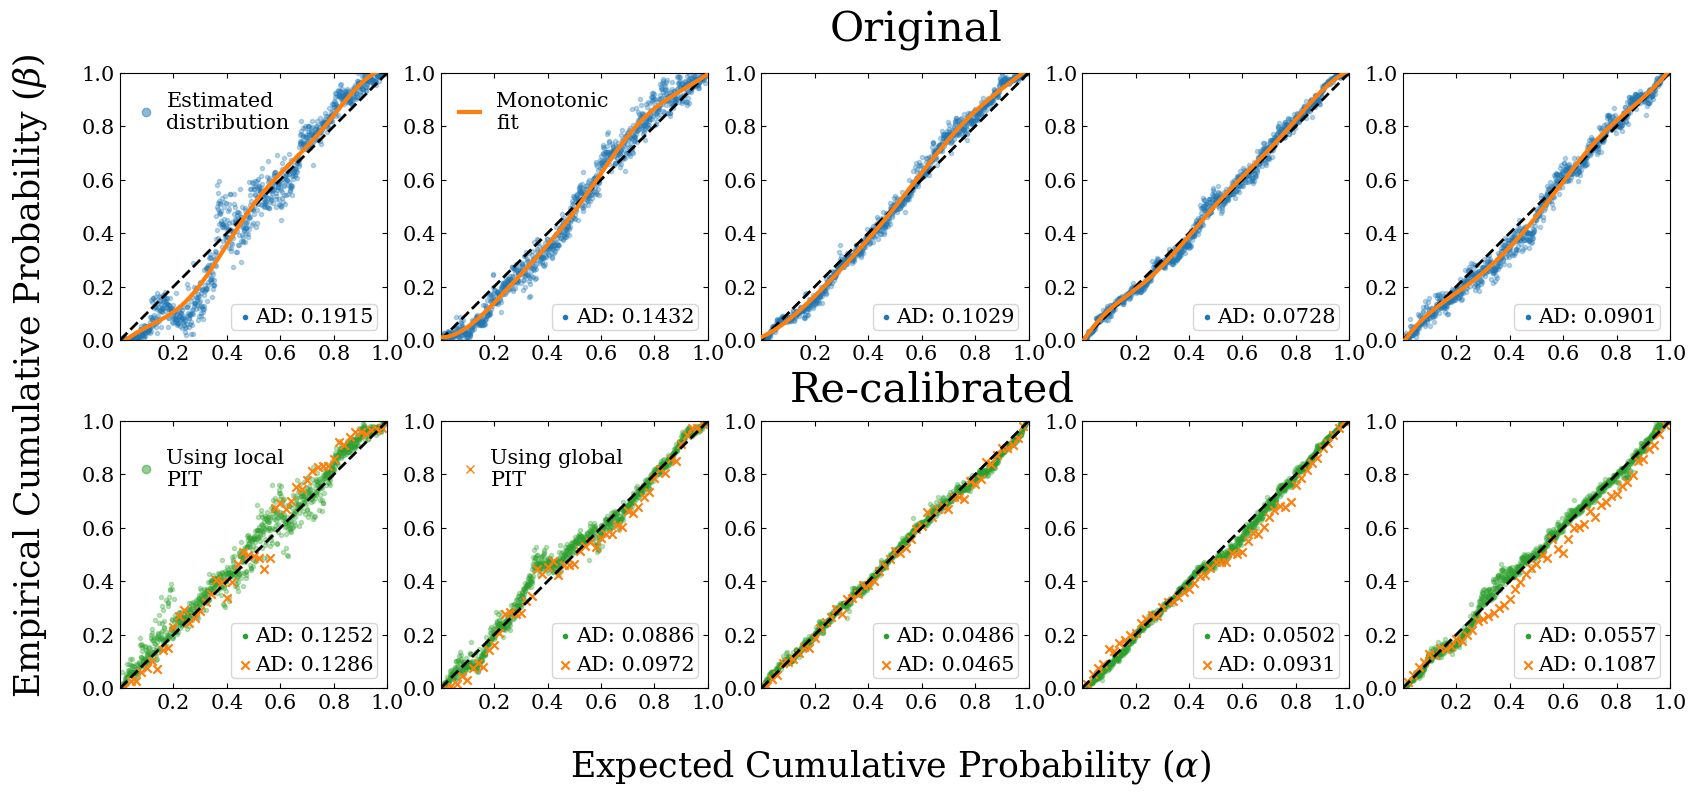

In [111]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
rng = np.random.default_rng(42)
random_idx = rng.choice(int((1-frac_val)*len(x_test_C)), 100, replace=False)
alphas = np.linspace(0.0, 1, 1001)
mask = (alphas>0.01) & (alphas<0.99)
for i in range(5):
    j=i+23
    ad = anderson_darling_statistic(pit_local_C[idx_C[idx_split_C:,]][random_idx[j]][mask], alphas[mask])
    ax[0,i].scatter(alphas, pit_local_C[idx_C[idx_split_C:,]][random_idx[j]], marker=".",c="C0", alpha=0.3, label=f"AD: {ad:.4f}")
    
    
    ax[0,i].plot(cdf_test_C[idx_C[idx_split_C:,]][random_idx[j]], pit_local_C_fit[idx_C[idx_split_C:,]][random_idx[j]], c="C1",lw=3, zorder=6)
    x= np.linspace(0,1,10)
    ax[0,i].plot(x,x,c="k",ls="--", lw=2)
    ax[0,i].set_aspect("equal")
    ax[0,i].set_xlim(0,1)
    ax[0,i].set_ylim(0,1)
    xlabels = np.linspace(0,1,6)[1:]
    ax[0,i].set_xticks(xlabels)
#     y_ticks = ax[0,i].get_yticklabels()
#     y_ticks[0].set_rotation(45)

    ax[0,i].tick_params(axis='x', labelsize=15 )
    ax[0,i].tick_params(axis='y', labelsize=15 )
    leg = ax[0,i].legend(loc="lower right", frameon=True, handletextpad=0.00001, prop={'size': 15}, borderpad=0.15, handlelength=1.0)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    
    ad = anderson_darling_statistic(pit_local_C_recal[random_idx[j]][mask], alphas[mask])
    ax[1,i].scatter(alphas, pit_local_C_recal[random_idx[j]], marker=".", alpha=0.3, c="C2", label=f"AD: {ad:.4f}")
    step = 20
    ad = anderson_darling_statistic(pit_global_C_recal[random_idx[j]][mask], alphas[mask])
    ax[1,i].scatter(alphas[::step], pit_global_C_recal[random_idx[j]][::step], marker="x", c="C1", label=f"AD: {ad:.4f}")
    ax[1,i].plot(x,x,c="k",ls="--", lw=2, zorder=6)
    ax[1,i].set_aspect("equal")
    ax[1,i].set_xlim(0,1)
    ax[1,i].set_ylim(0,1)
    ax[1,i].tick_params(axis='x', labelsize=15 )
    ax[1,i].tick_params(axis='y', labelsize=15 )
    ax[1,i].set_xticks(xlabels)
    leg = ax[1,i].legend(loc="lower right", handletextpad=0.00001, prop={'size': 15}, borderpad=0.15, handlelength=1)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    

    
fig.text(0.48,0.92,"Original", fontsize=30)
fig.text(0.46,0.47,"Re-calibrated", fontsize=30)

fig.text(0.35,0, r"Expected Cumulative Probability ($\alpha$)", fontsize=25)
fig.text(0.07,0.11, r"Empirical Cumulative Probability ($\beta$)",rotation=90, fontsize=25)
plt.subplots_adjust(hspace=0.3)

import matplotlib.lines as mlines

blue_dot = mlines.Line2D([], [], color='C0', marker='o', alpha=0.5, label='Estimated\ndistribution', ls="")
orange_line = mlines.Line2D([], [], color='C1', marker='', label='Monotonic\nfit', ls="-",lw=3)
fig.legend(bbox_to_anchor=[0.118,0.88], loc='upper left', handles=[blue_dot], ncol=1, prop={'size': 15}, frameon=False, handletextpad=0.00001)
fig.legend(bbox_to_anchor=[0.285,0.88], loc='upper left', handles=[orange_line], ncol=1, prop={'size': 15}, frameon=False,handlelength=1.0)

green_dot = mlines.Line2D([], [], color='C2', marker='o', alpha=0.5, label='Using local\nPIT', ls="")
orange_cross = mlines.Line2D([], [], color='C1', marker='x', label='Using global\nPIT', ls="")
fig.legend(bbox_to_anchor=[0.118,0.434], loc='upper left', handles=[green_dot], ncol=1, prop={'size': 15}, frameon=False, handletextpad=0.00001)
fig.legend(bbox_to_anchor=[0.28,0.434], loc='upper left', handles=[orange_cross], ncol=1, prop={'size': 15}, frameon=False, handletextpad=0.00001)


# plt.tight_layout()
plt.savefig("../figs/P-P_local.pdf", bbox_inches="tight")
plt.show()


In [10]:
# np.savez(
#     "../figs/data.npz",
#     cde_test_B=cde_test_B,
#     cde_test_C=cde_test_C,
#     cde_val=cde_val,
#     y_grid_val=y_grid_val,
#     y_grid_test_B=y_grid_test_B,
#     y_grid_test_C=y_grid_test_C,
#     correction_cde_B=correction_cde_B,
#     correction_cde_C=correction_cde_C,
#     correction_global_C=correction_global_C,
# )

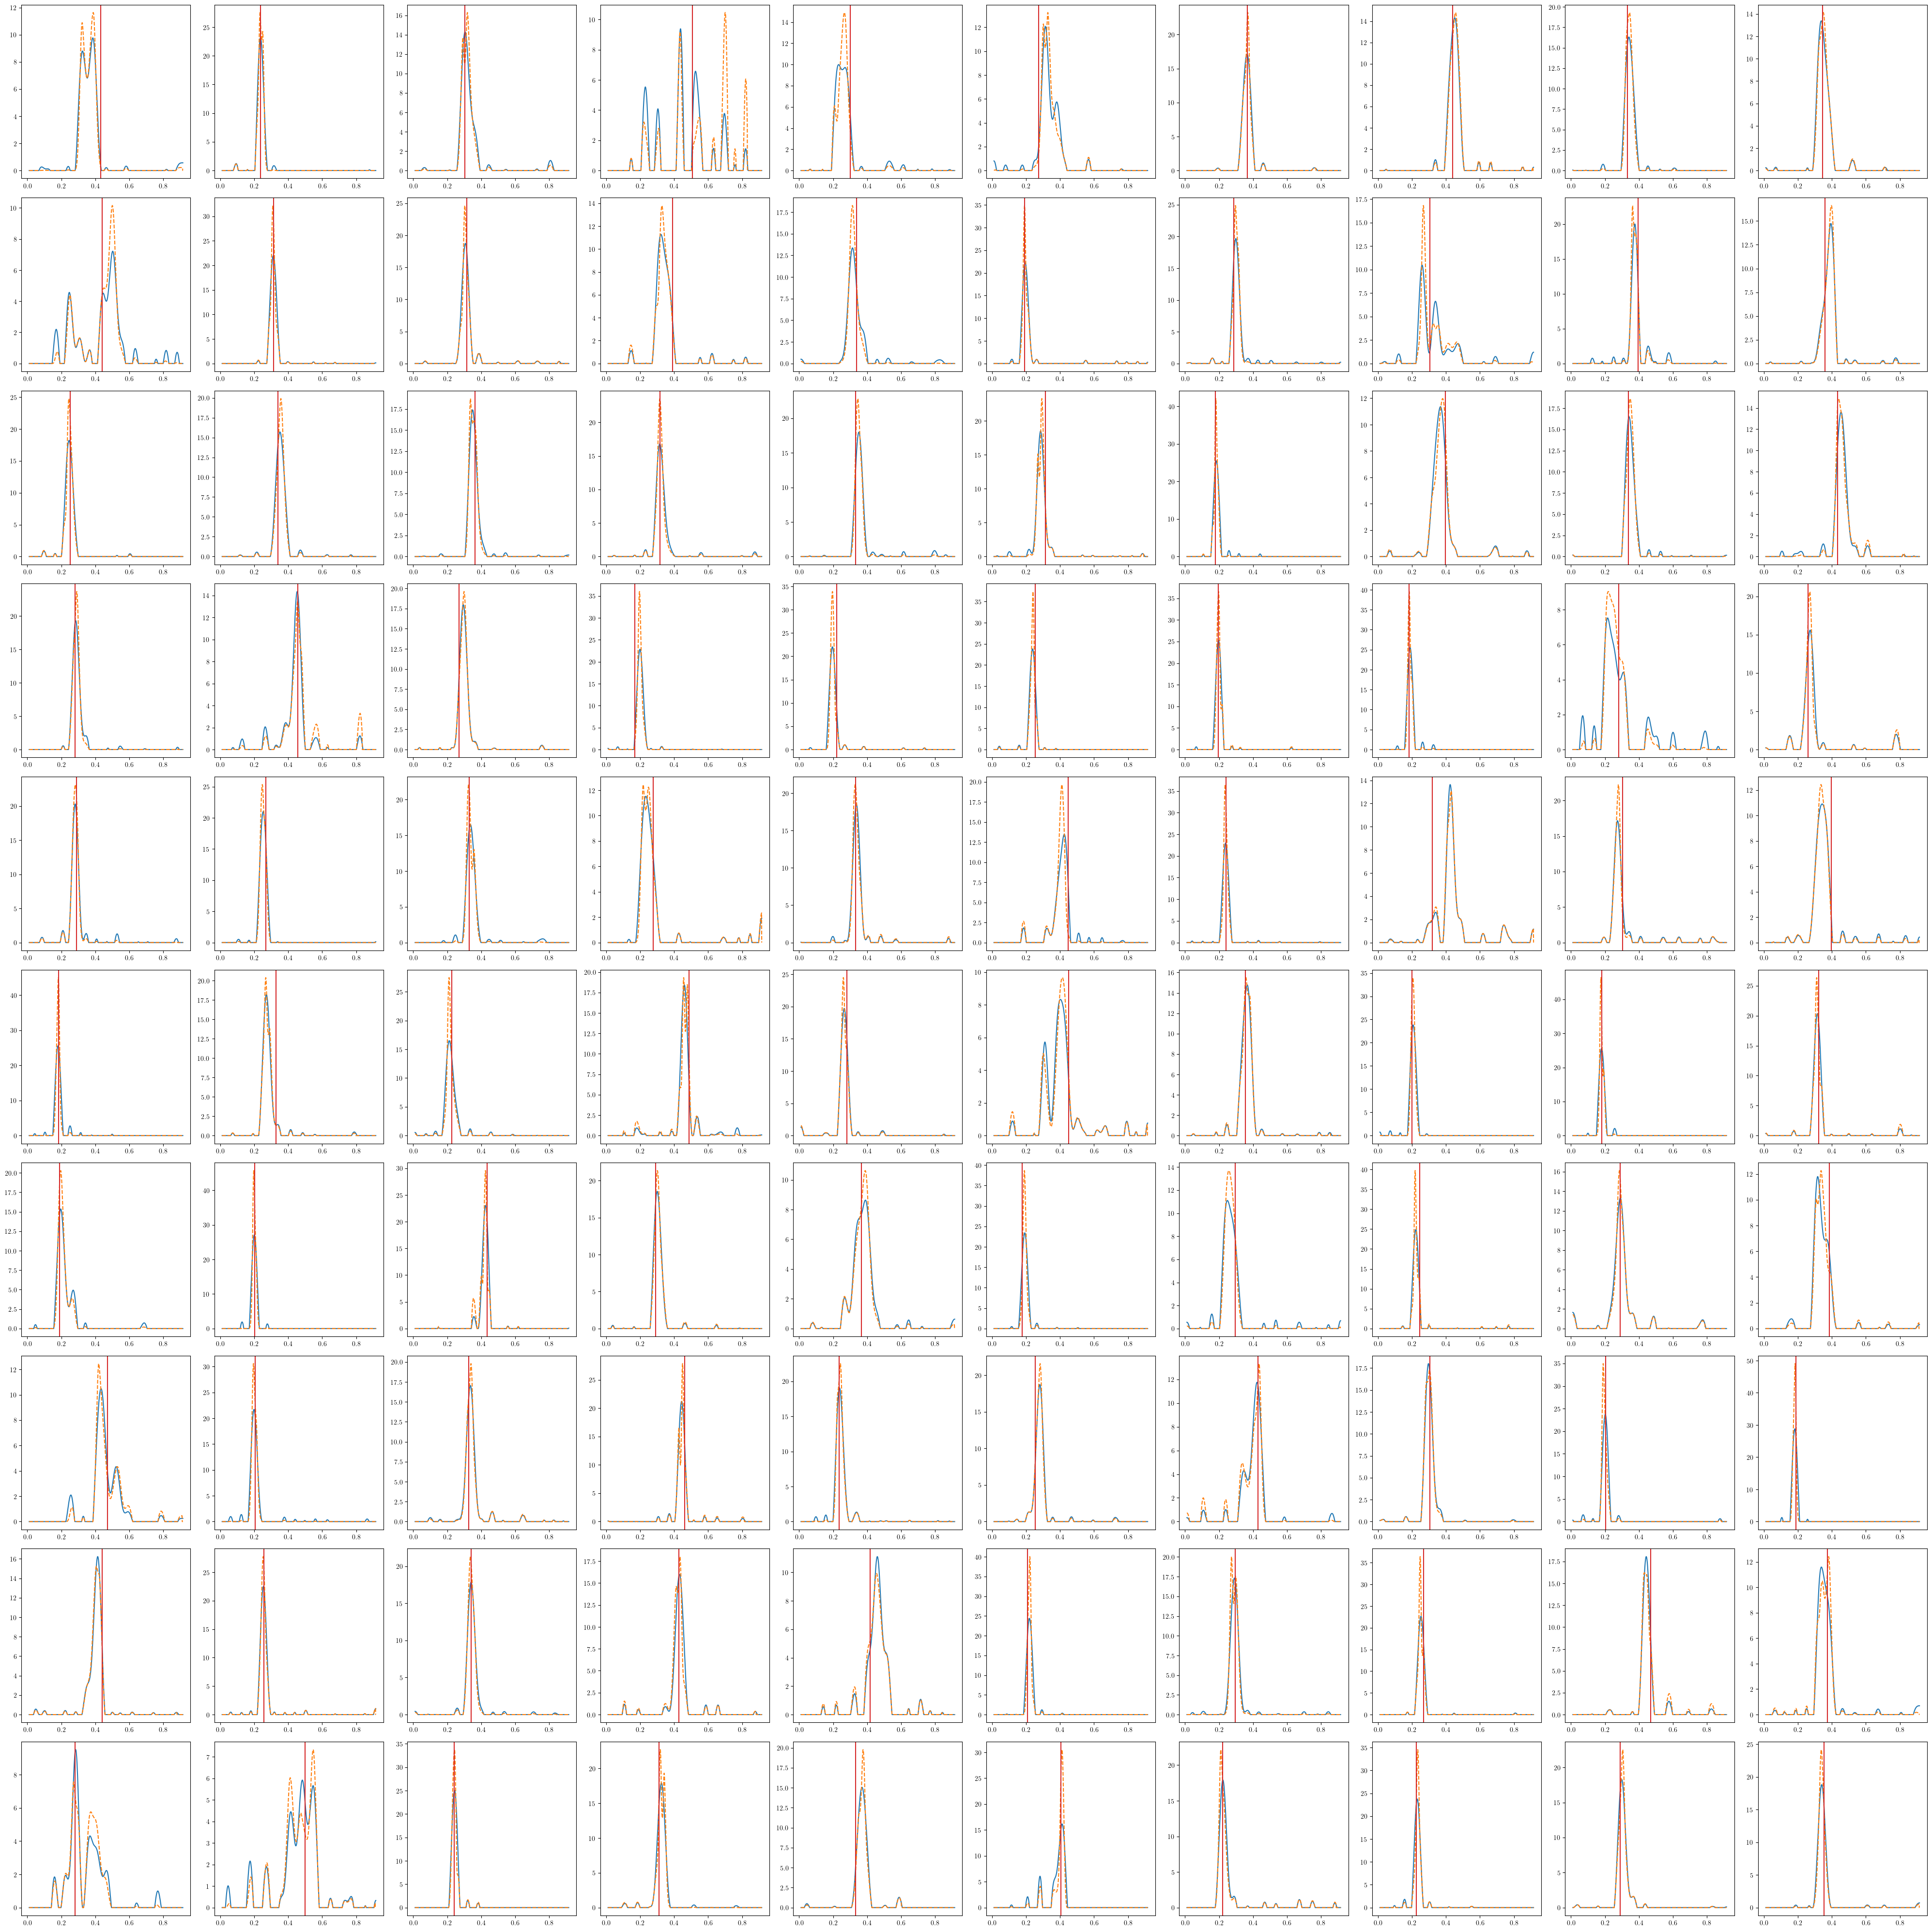

In [20]:
rng = np.random.default_rng(42)
idx = rng.choice(len(cde_test_B),100)

fig, ax = plt.subplots(10,10, figsize=(40,40))
ax = np.ravel(ax)

for count, j in enumerate(idx):
    ax[count].plot(y_grid_test_B, cde_test_B[j],)
    ax[count].plot(y_grid_test_B, debiased_pdf_bordoloi_B[j],ls="--")
    ax[count].axvline(y_test_B[j], 0, 1, c="C3")

# plt.xlabel("redshift")
# plt.title("CDE's from TEDDY B")
plt.savefig("../figs/teddy_B_pdf.pdf",bbox_inches="tight")
plt.tight_layout()
plt.show()

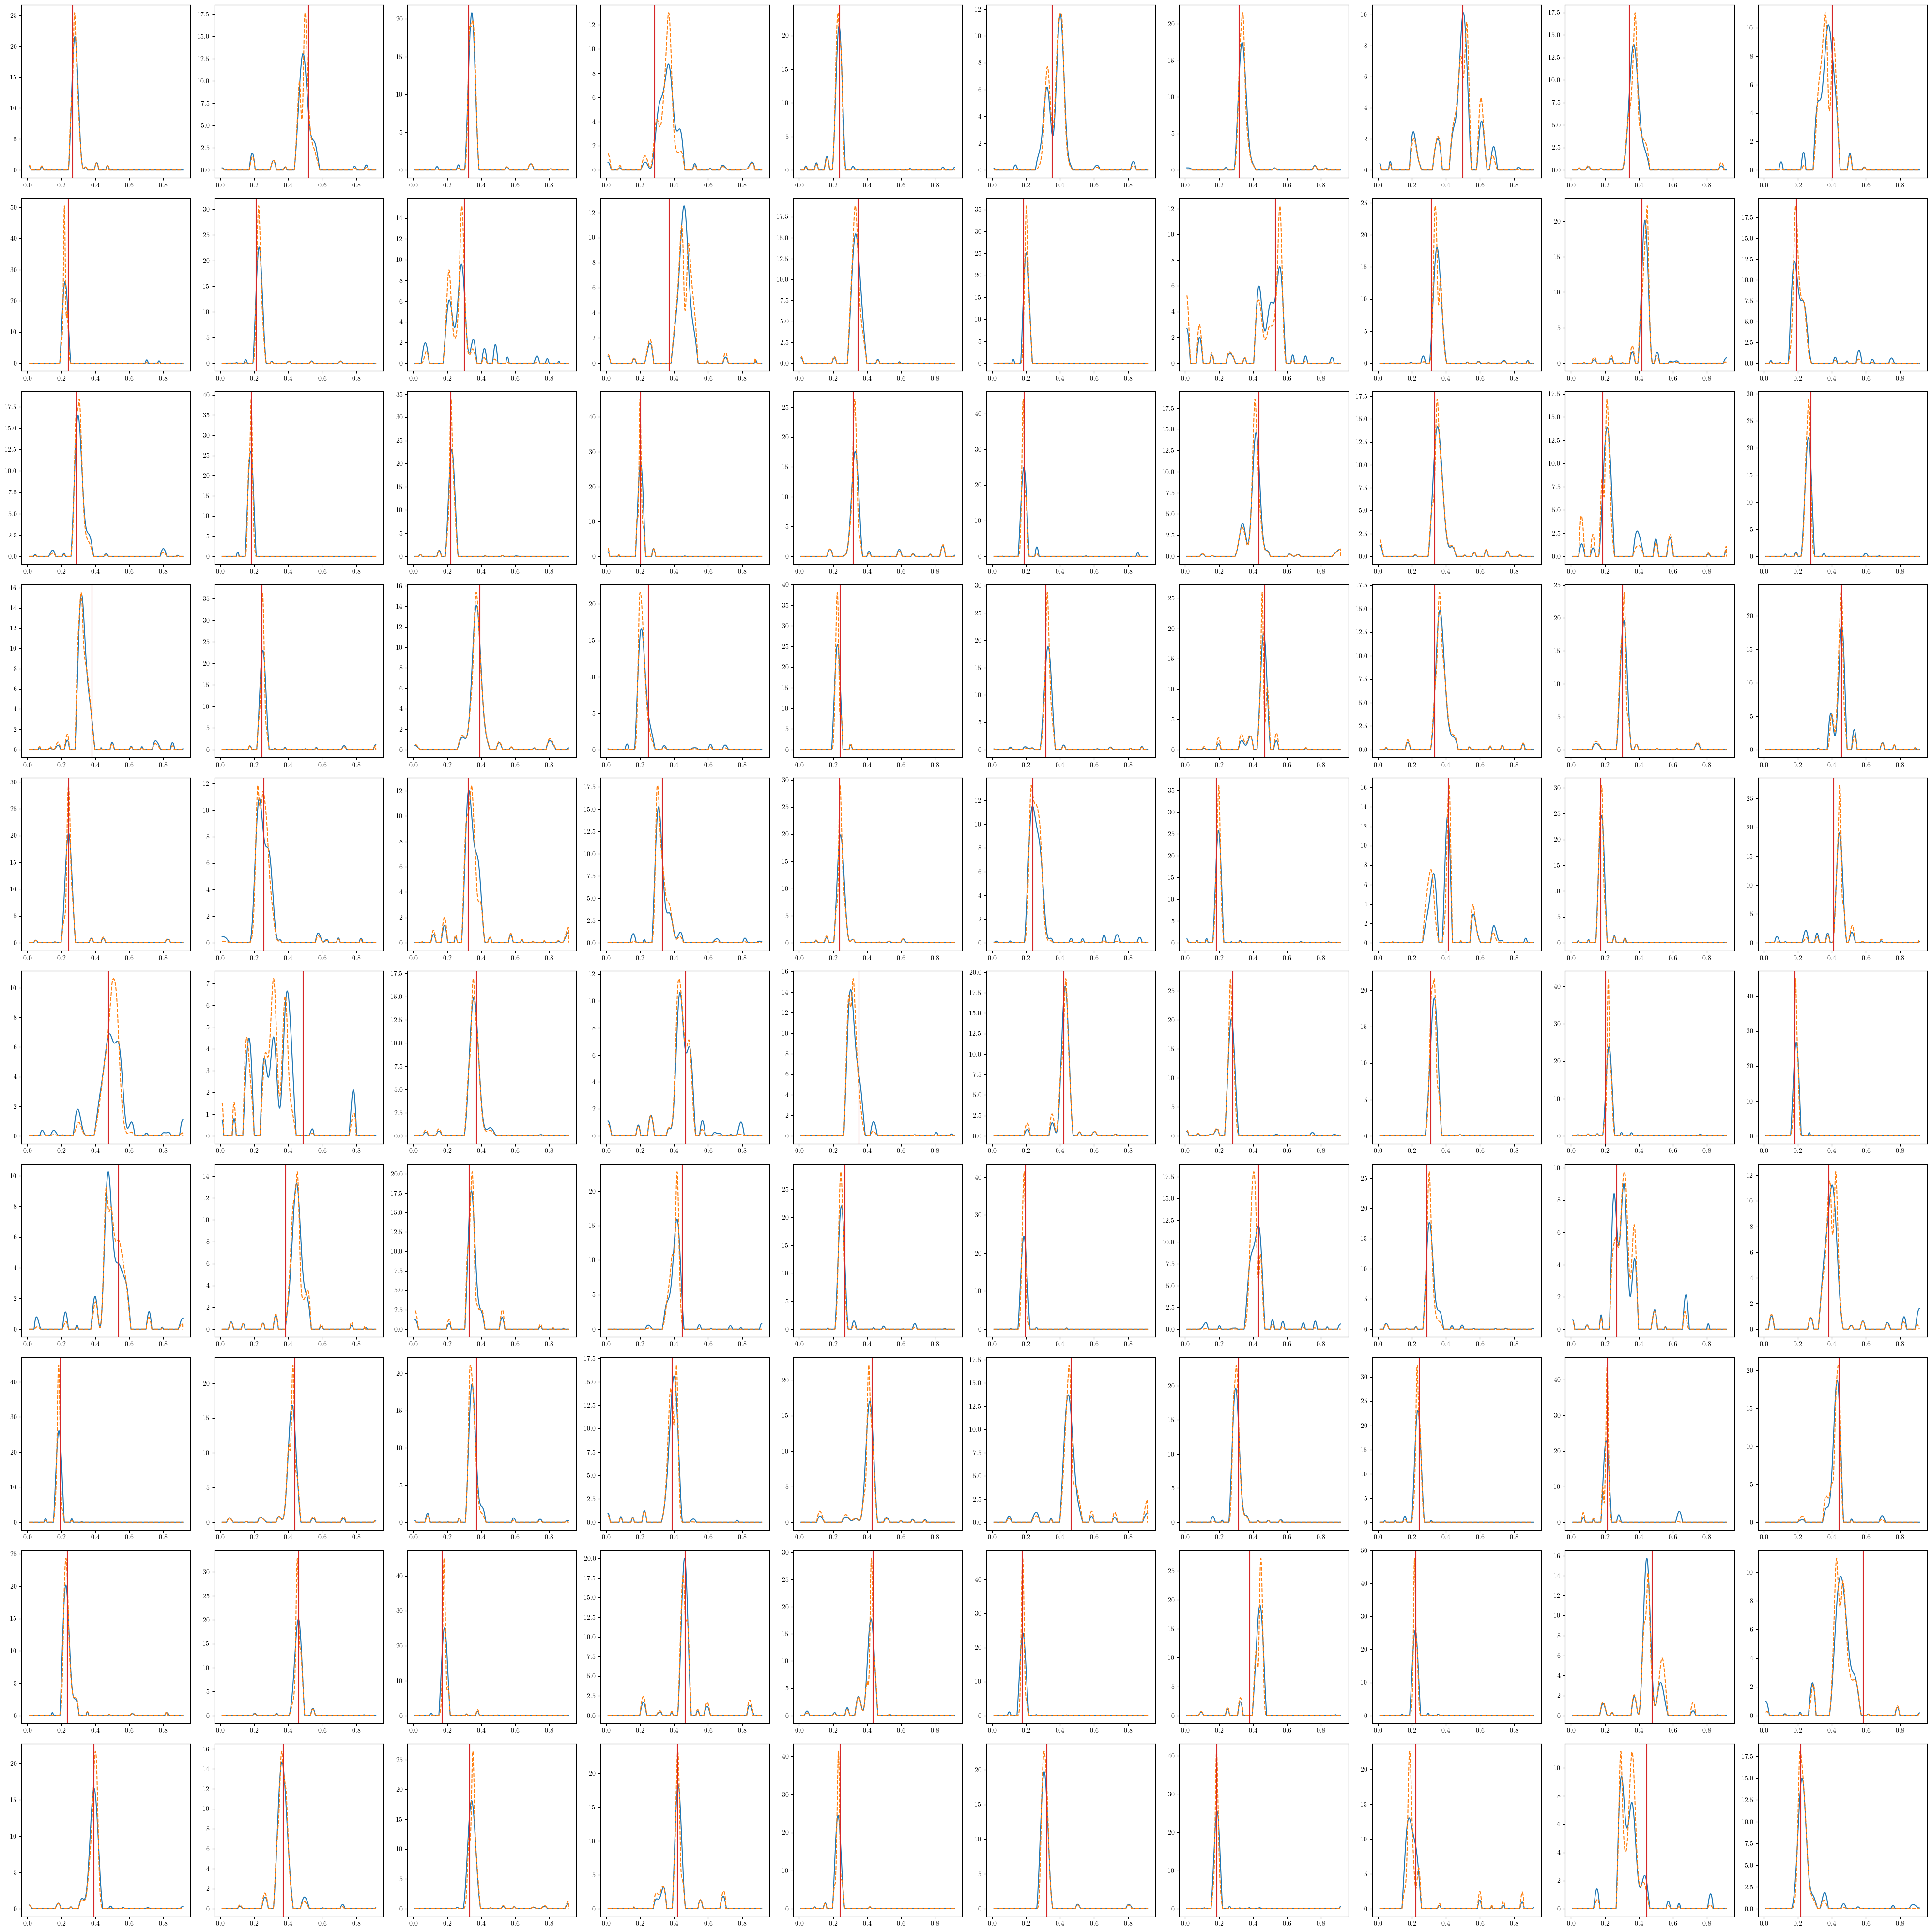

In [21]:
rng = np.random.default_rng(42)
idx = rng.choice(len(cde_test_C),100)

fig, ax = plt.subplots(10,10, figsize=(40,40))
ax = np.ravel(ax)

for count, j in enumerate(idx):
    ax[count].plot(y_grid_test_C, cde_test_C[j],)
    ax[count].plot(y_grid_test_C, debiased_pdf_bordoloi_C[j],ls="--")
    ax[count].axvline(y_test_C[j], 0, 1, c="C3")

# plt.xlabel("redshift")
# plt.title("CDE's from TEDDY B")
plt.savefig("../figs/teddy_C_pdf.pdf",bbox_inches="tight")
plt.tight_layout()
plt.show()